In [ ]:
import pandas as pd
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from tabpfn import TabPFNClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
import os
import pickle

In [2]:
df = pd.read_csv("encoded_clean_data.csv")

missing_ratio = df.isnull().mean()

# threshold 0.5
columns_to_drop = missing_ratio[missing_ratio > 0.5].index
print(list(columns_to_drop))

df = df.drop(columns=columns_to_drop)
df = df.drop(columns=["discharge_location"])
df = df.dropna()
# df.to_csv('encoded_clean_data2.csv', index=False)

['Temp_C', 'Urine', 'Vasopressor_NE', 'Loop_Diuretic', 'Vasopressor_PE', 'Insulin', 'Loop_Diuretic_alt', 'Insulin_alt', 'Vasopressin', 'Extubation_flag']


1. Case 1: On LACE scores only

In [3]:
features1 = ['Length', 'Acuity', 'Comorbidity', 'E', 'LACE']
target = 'readmitted'
df1 = df[features1 + [target]].dropna()
X1 = df1[features1]
y1 = df1[target]
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=42)
X1_train_resampled, y1_train_resampled = SMOTE(random_state=42).fit_resample(X1_train, y1_train)

In [5]:
results = {}

model_xgb1 = xgb.XGBClassifier(
    scale_pos_weight=len(y1_train_resampled[y1_train_resampled == 0]) / len(y1_train_resampled[y1_train_resampled == 1]),
    eval_metric='logloss',
)
model_xgb1.fit(X1_train_resampled, y1_train_resampled)
y_pred = model_xgb1.predict(X1_test)
y_prob = model_xgb1.predict_proba(X1_test)[:, 1]
results["XGBoost"] = (classification_report(y1_test, y_pred, output_dict=True), roc_auc_score(y1_test, y_prob))

model_rf1 = RandomForestClassifier(random_state=42)
model_rf1.fit(X1_train_resampled, y1_train_resampled)
y_pred = model_rf1.predict(X1_test)
y_prob = model_rf1.predict_proba(X1_test)[:, 1]
results["Random Forest"] = (classification_report(y1_test, y_pred, output_dict=True), roc_auc_score(y1_test, y_prob))

model_lr1 = LogisticRegression(max_iter=1000, solver='liblinear')
model_lr1.fit(X1_train_resampled, y1_train_resampled)
y_pred = model_lr1.predict(X1_test)
y_prob = model_lr1.predict_proba(X1_test)[:, 1]
results["Logistic Regression"] = (classification_report(y1_test, y_pred, output_dict=True), roc_auc_score(y1_test, y_prob))

model_lgb1 = LGBMClassifier(random_state=42, class_weight='balanced', verbose=-1)
model_lgb1.fit(X1_train_resampled, y1_train_resampled)
y_pred = model_lgb1.predict(X1_test)
y_prob = model_lgb1.predict_proba(X1_test)[:, 1]
results["LightGBM"] = (classification_report(y1_test, y_pred, output_dict=True), roc_auc_score(y1_test, y_prob))

model_cat1 = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, verbose=0, random_state=42)
model_cat1.fit(X1_train_resampled, y1_train_resampled)
y_pred = model_cat1.predict(X1_test)
y_prob = model_cat1.predict_proba(X1_test)[:, 1]
results["CatBoost"] = (classification_report(y1_test, y_pred, output_dict=True), roc_auc_score(y1_test, y_prob))

X_tabpfn = X1_train_resampled[:10000].values
y_tabpfn = y1_train_resampled[:10000].values
model_tabpfn1 = TabPFNClassifier(
    device="cuda" if torch.cuda.is_available() else "cpu",
    ignore_pretraining_limits=True
)
model_tabpfn1.fit(X_tabpfn, y_tabpfn)
y_prob = model_tabpfn1.predict_proba(X1_test.values)[:, 1]
y_pred = (y_prob > 0.4).astype(int)
results["TabPFNv2"] = (classification_report(y1_test, y_pred, output_dict=True), roc_auc_score(y1_test, y_prob))

summary_rows = []
for model_name, (report, auc) in results.items():
    wa = report["weighted avg"]
    summary_rows.append({
        "Model": model_name,
        "Precision": wa["precision"],
        "Recall": wa["recall"],
        "F1-score": wa["f1-score"],
        "Accuracy": report["accuracy"],
        "ROC AUC": auc
    })

df_summary_case1 = pd.DataFrame(summary_rows)
print(df_summary_case1.to_string(index=False))

# save models
joblib.dump(model_xgb1, "saved_models/model_xgb1.pkl")
joblib.dump(model_rf1, "saved_models/model_rf1.pkl")
joblib.dump(model_lr1, "saved_models/model_lr1.pkl")
joblib.dump(model_lgb1, "saved_models/model_lgb1.pkl")
joblib.dump(model_cat1, "saved_models/model_cat1.pkl")

with open("saved_models/model_tabpfn1.pkl", "wb") as f:
    pickle.dump(model_tabpfn1, f)

              Model  Precision   Recall  F1-score  Accuracy  ROC AUC
            XGBoost   0.658885 0.629426  0.635266  0.629426 0.688588
      Random Forest   0.658895 0.629553  0.635390  0.629553 0.688519
Logistic Regression   0.647620 0.626637  0.632127  0.626637 0.675283
           LightGBM   0.658631 0.635989  0.641479  0.635989 0.689211
           CatBoost   0.659282 0.629236  0.635082  0.629236 0.688616
           TabPFNv2   0.654034 0.646134  0.649140  0.646134 0.686187


2. Case 2: On all the features including LACE scores

In [6]:
target = 'readmitted'
df2 = df.drop(columns=["hadm_id", "los", "admission_type", "E_origin"]).iloc[:, :-17]
df2 = df2.dropna()
X2 = df2.drop(columns=[target])
y2 = df2[target]
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=42)
X2_train_resampled, y2_train_resampled = SMOTE(random_state=42).fit_resample(X2_train, y2_train)

In [7]:
results2 = {}

model_xgb2 = xgb.XGBClassifier(
    scale_pos_weight=len(y2_train_resampled[y2_train_resampled == 0]) / len(y2_train_resampled[y2_train_resampled == 1]),
    eval_metric='logloss'
)
model_xgb2.fit(X2_train_resampled, y2_train_resampled)
y2_pred = model_xgb2.predict(X2_test)
y2_prob = model_xgb2.predict_proba(X2_test)[:, 1]
results2["XGBoost"] = (classification_report(y2_test, y2_pred, output_dict=True), roc_auc_score(y2_test, y2_prob))

model_rf2 = RandomForestClassifier(random_state=42)
model_rf2.fit(X2_train_resampled, y2_train_resampled)
y2_pred = model_rf2.predict(X2_test)
y2_prob = model_rf2.predict_proba(X2_test)[:, 1]
results2["Random Forest"] = (classification_report(y2_test, y2_pred, output_dict=True), roc_auc_score(y2_test, y2_prob))

model_lr2 = LogisticRegression(max_iter=1000, solver='liblinear')
model_lr2.fit(X2_train_resampled, y2_train_resampled)
y2_pred = model_lr2.predict(X2_test)
y2_prob = model_lr2.predict_proba(X2_test)[:, 1]
results2["Logistic Regression"] = (classification_report(y2_test, y2_pred, output_dict=True), roc_auc_score(y2_test, y2_prob))

model_lgb2 = LGBMClassifier(random_state=42, class_weight='balanced', verbose=-1)
model_lgb2.fit(X2_train_resampled, y2_train_resampled)
y2_pred = model_lgb2.predict(X2_test)
y2_prob = model_lgb2.predict_proba(X2_test)[:, 1]
results2["LightGBM"] = (classification_report(y2_test, y2_pred, output_dict=True), roc_auc_score(y2_test, y2_prob))

model_cat2 = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, verbose=0, random_state=42)
model_cat2.fit(X2_train_resampled, y2_train_resampled)
y2_pred = model_cat2.predict(X2_test)
y2_prob = model_cat2.predict_proba(X2_test)[:, 1]
results2["CatBoost"] = (classification_report(y2_test, y2_pred, output_dict=True), roc_auc_score(y2_test, y2_prob))

X2_tabpfn = X2_train_resampled[:10000].values
y2_tabpfn = y2_train_resampled[:10000].values
model_tabpfn2 = TabPFNClassifier(
    device="cuda" if torch.cuda.is_available() else "cpu",
    ignore_pretraining_limits=True
)
model_tabpfn2.fit(X2_tabpfn, y2_tabpfn)
y2_prob = model_tabpfn2.predict_proba(X2_test.values)[:, 1]
y2_pred = (y2_prob > 0.4).astype(int)
results2["TabPFNv2"] = (classification_report(y2_test, y2_pred, output_dict=True), roc_auc_score(y2_test, y2_prob))

summary_rows2 = []
for model_name, (report, auc) in results2.items():
    wa = report["weighted avg"]
    summary_rows2.append({
        "Model": model_name,
        "Precision": wa["precision"],
        "Recall": wa["recall"],
        "F1-score": wa["f1-score"],
        "Accuracy": report["accuracy"],
        "ROC AUC": auc
    })

df_summary_case2 = pd.DataFrame(summary_rows2)
print(df_summary_case2.to_string(index=False))

# save models
joblib.dump(model_xgb2, "saved_models/model_xgb2.pkl")
joblib.dump(model_rf2, "saved_models/model_rf2.pkl")
joblib.dump(model_lr2, "saved_models/model_lr2.pkl")
joblib.dump(model_lgb2, "saved_models/model_lgb2.pkl")
joblib.dump(model_cat2, "saved_models/model_cat2.pkl")

with open("saved_models/model_tabpfn2.pkl", "wb") as f:
    pickle.dump(model_tabpfn2, f)

              Model  Precision   Recall  F1-score  Accuracy  ROC AUC
            XGBoost   0.768121 0.771423  0.766296  0.771423 0.816458
      Random Forest   0.831185 0.831627  0.828294  0.831627 0.900227
Logistic Regression   0.684245 0.691025  0.685713  0.691025 0.724787
           LightGBM   0.736121 0.740164  0.736944  0.740164 0.785101
           CatBoost   0.786899 0.788606  0.782906  0.788606 0.831102
           TabPFNv2   0.702986 0.697302  0.699467  0.697302 0.749976


3. Case 3: On all the features including LACE features, but with their actual values

In [8]:
target = 'readmitted'
df3 = df.drop(columns=["hadm_id", "Length", "Acuity", "E", "Comorbidity","LACE"])
df3 = df3.dropna()
X3 = df3.drop(columns=[target])
y3 = df3[target]
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3, random_state=42)
X3_train_resampled, y3_train_resampled = SMOTE(random_state=42).fit_resample(X3_train, y3_train)

In [9]:
results3 = {}

model_xgb3 = xgb.XGBClassifier(
    scale_pos_weight=len(y3_train_resampled[y3_train_resampled == 0]) / len(y3_train_resampled[y3_train_resampled == 1]),
    eval_metric='logloss'
)
model_xgb3.fit(X3_train_resampled, y3_train_resampled)
y3_pred = model_xgb3.predict(X3_test)
y3_prob = model_xgb3.predict_proba(X3_test)[:, 1]
results3["XGBoost"] = (classification_report(y3_test, y3_pred, output_dict=True), roc_auc_score(y3_test, y3_prob))

model_rf3 = RandomForestClassifier(random_state=42)
model_rf3.fit(X3_train_resampled, y3_train_resampled)
y3_pred = model_rf3.predict(X3_test)
y3_prob = model_rf3.predict_proba(X3_test)[:, 1]
results3["Random Forest"] = (classification_report(y3_test, y3_pred, output_dict=True), roc_auc_score(y3_test, y3_prob))

model_lr3 = LogisticRegression(max_iter=1000, solver='liblinear')
model_lr3.fit(X3_train_resampled, y3_train_resampled)
y3_pred = model_lr3.predict(X3_test)
y3_prob = model_lr3.predict_proba(X3_test)[:, 1]
results3["Logistic Regression"] = (classification_report(y3_test, y3_pred, output_dict=True), roc_auc_score(y3_test, y3_prob))

model_lgb3 = LGBMClassifier(random_state=42, class_weight='balanced', verbose=-1)
model_lgb3.fit(X3_train_resampled, y3_train_resampled)
y3_pred = model_lgb3.predict(X3_test)
y3_prob = model_lgb3.predict_proba(X3_test)[:, 1]
results3["LightGBM"] = (classification_report(y3_test, y3_pred, output_dict=True), roc_auc_score(y3_test, y3_prob))

model_cat3 = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, verbose=0, random_state=42)
model_cat3.fit(X3_train_resampled, y3_train_resampled)
y3_pred = model_cat3.predict(X3_test)
y3_prob = model_cat3.predict_proba(X3_test)[:, 1]
results3["CatBoost"] = (classification_report(y3_test, y3_pred, output_dict=True), roc_auc_score(y3_test, y3_prob))

summary_rows3 = []
for model_name, (report, auc) in results3.items():
    wa = report["weighted avg"]
    summary_rows3.append({
        "Model": model_name,
        "Precision": wa["precision"],
        "Recall": wa["recall"],
        "F1-score": wa["f1-score"],
        "Accuracy": report["accuracy"],
        "ROC AUC": auc
    })

df_summary_case3 = pd.DataFrame(summary_rows3)
print(df_summary_case3.to_string(index=False))

# save models
joblib.dump(model_xgb3, "saved_models/model_xgb3.pkl")
joblib.dump(model_rf3, "saved_models/model_rf3.pkl")
joblib.dump(model_lr3, "saved_models/model_lr3.pkl")
joblib.dump(model_lgb3, "saved_models/model_lgb3.pkl")
joblib.dump(model_cat3, "saved_models/model_cat3.pkl")

              Model  Precision   Recall  F1-score  Accuracy  ROC AUC
            XGBoost   0.760343 0.764100  0.759714  0.764100 0.810348
      Random Forest   0.819813 0.821418  0.818887  0.821418 0.894974
Logistic Regression   0.672838 0.669150  0.670735  0.669150 0.704316
           LightGBM   0.727584 0.730844  0.728659  0.730844 0.778060
           CatBoost   0.781558 0.783787  0.778235  0.783787 0.828365


['saved_models/model_cat3.pkl']

4. Case: All features

In [10]:
target = 'readmitted'
df4 = df.drop(columns=["hadm_id"])
df4 = df4.dropna()
X4 = df4.drop(columns=[target])
y4 = df4[target]
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.3, random_state=42)
X4_train_resampled, y4_train_resampled = SMOTE(random_state=42).fit_resample(X4_train, y4_train)

In [11]:
results4 = {}

model_xgb4 = xgb.XGBClassifier(
    scale_pos_weight=len(y4_train_resampled[y4_train_resampled == 0]) / len(y4_train_resampled[y4_train_resampled == 1]),
    eval_metric='logloss'
)
model_xgb4.fit(X4_train_resampled, y4_train_resampled)
y4_pred = model_xgb4.predict(X4_test)
y4_prob = model_xgb4.predict_proba(X4_test)[:, 1]
results4["XGBoost"] = (classification_report(y4_test, y4_pred, output_dict=True), roc_auc_score(y4_test, y4_prob))

model_rf4 = RandomForestClassifier(random_state=42)
model_rf4.fit(X4_train_resampled, y4_train_resampled)
y4_pred = model_rf4.predict(X4_test)
y4_prob = model_rf4.predict_proba(X4_test)[:, 1]
results4["Random Forest"] = (classification_report(y4_test, y4_pred, output_dict=True), roc_auc_score(y4_test, y4_prob))

model_lr4 = LogisticRegression(max_iter=1000, solver='liblinear')
model_lr4.fit(X4_train_resampled, y4_train_resampled)
y4_pred = model_lr4.predict(X4_test)
y4_prob = model_lr4.predict_proba(X4_test)[:, 1]
results4["Logistic Regression"] = (classification_report(y4_test, y4_pred, output_dict=True), roc_auc_score(y4_test, y4_prob))

model_lgb4 = LGBMClassifier(random_state=42, class_weight='balanced', verbose=-1)
model_lgb4.fit(X4_train_resampled, y4_train_resampled)
y4_pred = model_lgb4.predict(X4_test)
y4_prob = model_lgb4.predict_proba(X4_test)[:, 1]
results4["LightGBM"] = (classification_report(y4_test, y4_pred, output_dict=True), roc_auc_score(y4_test, y4_prob))

model_cat4 = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, verbose=0, random_state=42)
model_cat4.fit(X4_train_resampled, y4_train_resampled)
y4_pred = model_cat4.predict(X4_test)
y4_prob = model_cat4.predict_proba(X4_test)[:, 1]
results4["CatBoost"] = (classification_report(y4_test, y4_pred, output_dict=True), roc_auc_score(y4_test, y4_prob))

summary_rows4 = []
for model_name, (report, auc) in results4.items():
    wa = report["weighted avg"]
    summary_rows4.append({
        "Model": model_name,
        "Precision": wa["precision"],
        "Recall": wa["recall"],
        "F1-score": wa["f1-score"],
        "Accuracy": report["accuracy"],
        "ROC AUC": auc
    })

df_summary_case4 = pd.DataFrame(summary_rows4)
print(df_summary_case4.to_string(index=False))

# save models
joblib.dump(model_xgb4, "saved_models/model_xgb4.pkl")
joblib.dump(model_rf4, "saved_models/model_rf4.pkl")
joblib.dump(model_lr4, "saved_models/model_lr4.pkl")
joblib.dump(model_lgb4, "saved_models/model_lgb4.pkl")
joblib.dump(model_cat4, "saved_models/model_cat4.pkl")

              Model  Precision   Recall  F1-score  Accuracy  ROC AUC
            XGBoost   0.776812 0.779761  0.775201  0.779761 0.823313
      Random Forest   0.835653 0.836033  0.832915  0.836033 0.902621
Logistic Regression   0.683448 0.690074  0.684987  0.690074 0.725545
           LightGBM   0.743114 0.747234  0.743615  0.747234 0.792621
           CatBoost   0.794111 0.795549  0.790290  0.795549 0.839871


['saved_models/model_cat4.pkl']

5. Comparsion

In [12]:
df_summary_case1["Case"] = "Case 1"
df_summary_case2["Case"] = "Case 2"
df_summary_case3["Case"] = "Case 3"
df_summary_case4["Case"] = "Case 4"

df_summary_all = pd.concat([df_summary_case1, df_summary_case2, df_summary_case3, df_summary_case4], ignore_index=True)
cols = ["Case"] + [col for col in df_summary_all.columns if col != "Case"]
df_summary_all = df_summary_all[cols]

print(df_summary_all.sort_values(by=["Model", "Case"]).to_string(index=False))
print()
print(df_summary_all.sort_values(by=["Case", "Model"]).to_string(index=False))

# sorted_by_model = df_summary_all.sort_values(by=["Model", "Case"])
# sorted_by_case = df_summary_all.sort_values(by=["Case", "Model"])

# # output
# with pd.ExcelWriter("model_comparison.xlsx") as writer:
#     sorted_by_model.to_excel(writer, sheet_name="By_Model_Case", index=False)
#     sorted_by_case.to_excel(writer, sheet_name="By_Case_Model", index=False)

  Case               Model  Precision   Recall  F1-score  Accuracy  ROC AUC
Case 1            CatBoost   0.659282 0.629236  0.635082  0.629236 0.688616
Case 2            CatBoost   0.786899 0.788606  0.782906  0.788606 0.831102
Case 3            CatBoost   0.781558 0.783787  0.778235  0.783787 0.828365
Case 4            CatBoost   0.794111 0.795549  0.790290  0.795549 0.839871
Case 1            LightGBM   0.658631 0.635989  0.641479  0.635989 0.689211
Case 2            LightGBM   0.736121 0.740164  0.736944  0.740164 0.785101
Case 3            LightGBM   0.727584 0.730844  0.728659  0.730844 0.778060
Case 4            LightGBM   0.743114 0.747234  0.743615  0.747234 0.792621
Case 1 Logistic Regression   0.647620 0.626637  0.632127  0.626637 0.675283
Case 2 Logistic Regression   0.684245 0.691025  0.685713  0.691025 0.724787
Case 3 Logistic Regression   0.672838 0.669150  0.670735  0.669150 0.704316
Case 4 Logistic Regression   0.683448 0.690074  0.684987  0.690074 0.725545
Case 1      

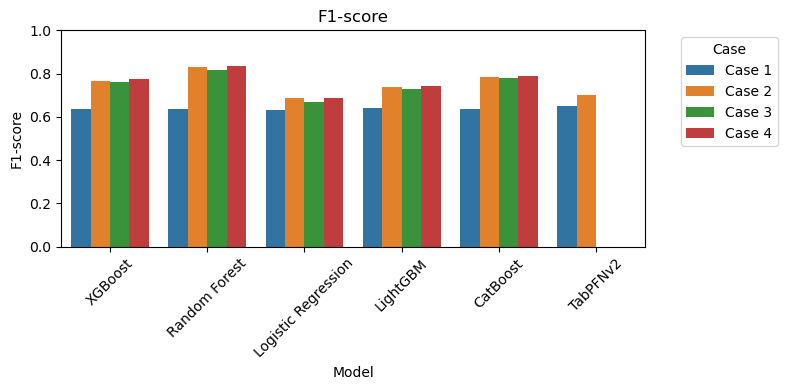

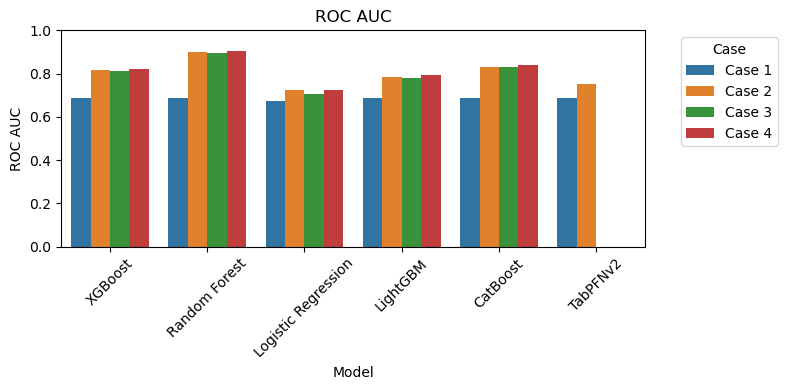

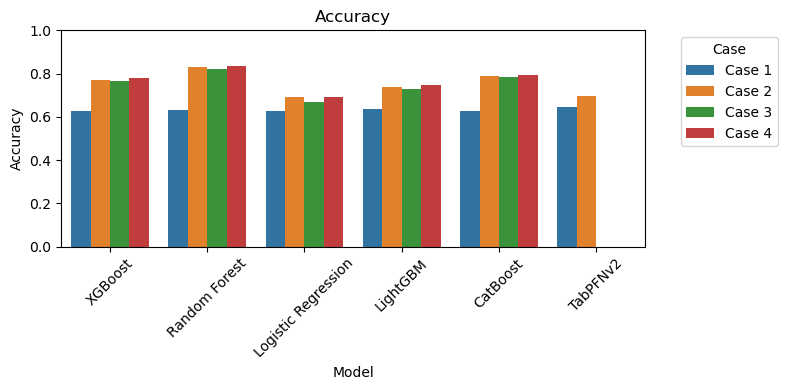

In [13]:
plt.figure(figsize=(8, 4))
sns.barplot(data=df_summary_all, x="Model", y="F1-score", hue="Case")
plt.title("F1-score")
plt.ylim(0, 1)
plt.legend(title="Case", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.barplot(data=df_summary_all, x="Model", y="ROC AUC", hue="Case")
plt.title("ROC AUC")
plt.ylim(0, 1)
plt.legend(title="Case", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.barplot(data=df_summary_all, x="Model", y="Accuracy", hue="Case")
plt.title("Accuracy")
plt.ylim(0, 1)
plt.legend(title="Case", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

6. Importance

100%|===================| 31477/31543 [02:01<00:00]        

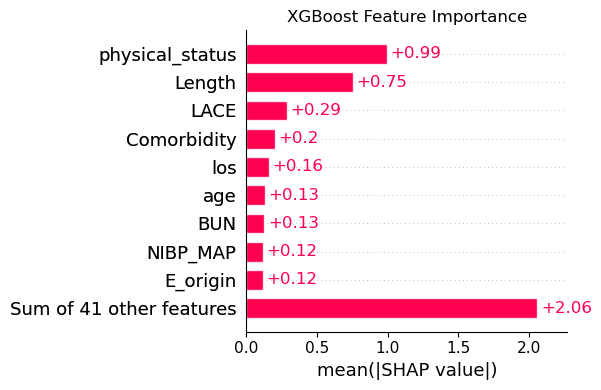

In [14]:
explainer_xgb = shap.Explainer(model_xgb4, X4_train_resampled)
shap_values_xgb = explainer_xgb(X4_test)
shap.plots.bar(shap_values_xgb, show=False)
plt.gcf().set_size_inches(6, 4)
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()

In [15]:
mean_abs_shap = np.abs(shap_values_xgb.values).mean(axis=0)

feature_importance = pd.DataFrame({
    'feature': X4_test.columns,
    'mean_abs_shap': mean_abs_shap
})

top20 = feature_importance.sort_values(by='mean_abs_shap', ascending=False).head(20)

print(top20.reset_index(drop=True))

               feature  mean_abs_shap
0      physical_status       0.991178
1               Length       0.750845
2                 LACE       0.289114
3          Comorbidity       0.202413
4                  los       0.157732
5                  age       0.133456
6                  BUN       0.127539
7             NIBP_MAP       0.118641
8             E_origin       0.117423
9                  WBC       0.099523
10                  HR       0.097053
11  admission_location       0.095519
12           insurance       0.091774
13            NIBP_DIA       0.091198
14              Acuity       0.089331
15                 Hgb       0.086452
16               Renal       0.082623
17            NIBP_SYS       0.081264
18             Glucose       0.074723
19                SpO2       0.069210


100%|===================| 31509/31543 [12:14<00:00]        

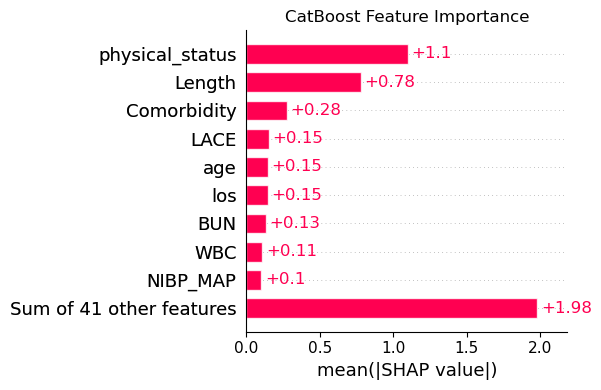

In [19]:
explainer_cat = shap.Explainer(model_cat4, X4_train_resampled)
shap_values_cat = explainer_cat(X4_test)
shap.plots.bar(shap_values_cat, show=False)
plt.gcf().set_size_inches(6, 4)
plt.title("CatBoost Feature Importance")
plt.tight_layout()
plt.show()

In [20]:
mean_abs_shap_cat = np.abs(shap_values_cat.values).mean(axis=0)

feature_importance_cat = pd.DataFrame({
    'feature': X4_test.columns,
    'mean_abs_shap': mean_abs_shap_cat
})

top20_cat = feature_importance_cat.sort_values(by='mean_abs_shap', ascending=False).head(20)

print(top20_cat.reset_index(drop=True))

               feature  mean_abs_shap
0      physical_status       1.098086
1               Length       0.776487
2          Comorbidity       0.276685
3                 LACE       0.152235
4                  age       0.148201
5                  los       0.147182
6                  BUN       0.134675
7                  WBC       0.109408
8             NIBP_MAP       0.102974
9                   HR       0.095092
10                SpO2       0.086896
11            E_origin       0.085067
12           insurance       0.084949
13  admission_location       0.084650
14            NIBP_SYS       0.081517
15                 Hgb       0.076085
16               Renal       0.074622
17                  RR       0.072818
18       patientweight       0.072400
19            NIBP_DIA       0.069655


100%|===================| 31403/31543 [02:33<00:00]        

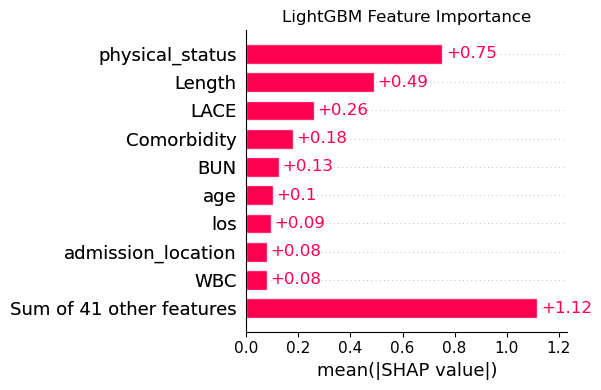

In [22]:
explainer_lgb = shap.Explainer(model_lgb4, X4_train_resampled)
shap_values_lgb = explainer_lgb(X4_test)
shap.plots.bar(shap_values_lgb, show=False)
plt.gcf().set_size_inches(6, 4)
plt.title("LightGBM Feature Importance")
plt.tight_layout()
plt.show()

In [23]:
mean_abs_shap_lgb = np.abs(shap_values_xgb.values).mean(axis=0)

feature_importance_lgb = pd.DataFrame({
    'feature': X4_test.columns,
    'mean_abs_shap': mean_abs_shap_lgb
})

top20_lgb = feature_importance_lgb.sort_values(by='mean_abs_shap', ascending=False).head(20)

print(top20_lgb.reset_index(drop=True))

               feature  mean_abs_shap
0      physical_status       0.991178
1               Length       0.750845
2                 LACE       0.289114
3          Comorbidity       0.202413
4                  los       0.157732
5                  age       0.133456
6                  BUN       0.127539
7             NIBP_MAP       0.118641
8             E_origin       0.117423
9                  WBC       0.099523
10                  HR       0.097053
11  admission_location       0.095519
12           insurance       0.091774
13            NIBP_DIA       0.091198
14              Acuity       0.089331
15                 Hgb       0.086452
16               Renal       0.082623
17            NIBP_SYS       0.081264
18             Glucose       0.074723
19                SpO2       0.069210


In [30]:
top20_xgb_features = set(top20['feature'])
top20_cat_features = set(top20_cat['feature'])
top20_lgb_features = set(top20_lgb['feature'])
common_features = top20_xgb_features & top20_cat_features & top20_lgb_features

print("Common features of XGB Cat & LGB:")
print(sorted(common_features))

unique_xgb = top20_xgb_features - (top20_cat_features | top20_lgb_features)
unique_cat = top20_cat_features - (top20_xgb_features | top20_lgb_features)
unique_lgb = top20_lgb_features - (top20_xgb_features | top20_cat_features)

print("Features unique to XGB:")
print(sorted(unique_xgb))

print("Features unique to Cat:")
print(sorted(unique_cat))

print("Features unique to LGB:")
print(sorted(unique_lgb))

Common features of XGB Cat & LGB:
['BUN', 'Comorbidity', 'E_origin', 'HR', 'Hgb', 'LACE', 'Length', 'NIBP_DIA', 'NIBP_MAP', 'NIBP_SYS', 'Renal', 'SpO2', 'WBC', 'admission_location', 'age', 'insurance', 'los', 'physical_status']
Features unique to XGB:
[]
Features unique to Cat:
['RR', 'patientweight']
Features unique to LGB:
[]
